/home/u101753/.conda/envs/MedSegDiff/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


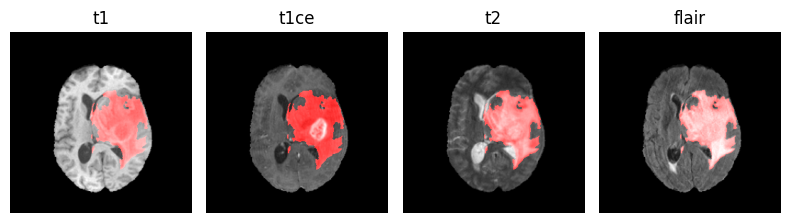

In [1]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
tran_list = [transforms.Resize((256,256)),]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

import matplotlib.pyplot as plt
from scipy import ndimage

b, m, slide_id = next(iter(datal))

from guided_diffusion.utils import visualize
visualize(b, m, gt=True)

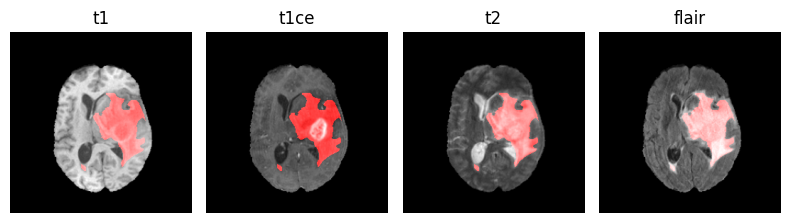

In [2]:
visualize(b, m)